In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

#### Import Data

In [2]:
center_surround_test = pd.read_csv('center_surround_test.csv')
center_surround_train = pd.read_csv('center_surround_train.csv')
center_surround_valid = pd.read_csv('center_surround_valid.csv')
spiral_test = pd.read_csv('spiral_test.csv')
spiral_train = pd.read_csv('spiral_train.csv')
spiral_valid = pd.read_csv('spiral_valid.csv')
two_gaussians_test = pd.read_csv('two_gaussians_test.csv')
two_gaussians_train = pd.read_csv('two_gaussians_train.csv')
two_gaussians_valid = pd.read_csv('two_gaussians_valid.csv')
xor_test = pd.read_csv('xor_test.csv')
xor_train = pd.read_csv('xor_train.csv')
xor_valid = pd.read_csv('xor_valid.csv')

#### Set additional parameters

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### 1 - PyTorch Implementation with MCE

In [4]:
class Data(Dataset):
  def __init__(self, data, targets):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.labels = torch.tensor(targets, dtype=torch.float32)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

class FeedForward(nn.Module):
  def __init__(self, size_in, size_out, k, device=device):
    super(FeedForward, self).__init__()
    self.linearStack = nn.Sequential(
        nn.Linear(size_in, k),
        nn.LeakyReLU(),
        nn.Linear(k, size_out),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.linearStack(x)
    return x
  
def train_model(model, dataloader, criterion, optimizer, device):
  model.train()
  tot_train_loss = 0
  for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data).squeeze()
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      tot_train_loss += loss.item()
  return tot_train_loss / len(dataloader)

def evaluate_model(model, dataloader, criterion, device):
  model.eval()
  targets = []
  predictions = []
  total_loss = 0
  with torch.no_grad():
      for data, target in dataloader:
          data, target = data.to(device), target.to(device)
          output = model(data).squeeze()
          loss = criterion(output, target)
          total_loss += loss.item()
          predictions.extend(output.cpu().numpy())
          targets.extend(target.cpu().numpy())
  # Calculate binary classification metrics
  predictions = np.array(predictions) > 0.5  # Threshold at 0.5
  accuracy = accuracy_score(targets, predictions)
  auc = roc_auc_score(targets, predictions)
  avg_loss = total_loss / len(dataloader)
  return accuracy, auc, avg_loss

def process_data(train_df, valid_df, test_df, batch_size, shuffle):
  # set up data
  train_data_df = train_df.loc[:, train_df.columns != 'label']
  train_target_df = train_df['label']
  valid_data_df = valid_df.loc[:, valid_df.columns != 'label']
  valid_target_df = valid_df['label']
  test_data_df = test_df.loc[:, test_df.columns != 'label']
  test_target_df = test_df['label']

  len_features = len(train_data_df.columns)

  # fit and transform data
  sc = MinMaxScaler()
  train_data_df = sc.fit_transform(train_data_df)
  test_data_df = sc.transform(test_data_df)
  valid_data_df = sc.transform(valid_data_df)

  # set up and implement data loaders
  train_data = Data(train_data_df, train_target_df)
  valid_data = Data(valid_data_df, valid_target_df)
  test_data = Data(test_data_df, test_target_df)
  train_loader = DataLoader(train_data, batch_size, shuffle)
  valid_loader = DataLoader(valid_data, batch_size, shuffle)
  test_loader = DataLoader(test_data, batch_size, shuffle)

  return train_loader, valid_loader, test_loader, len_features

In [ ]:
# Hyperparameters
batch_size = 32 # training batch size
shuffle = False # shuffle data before training
k = 5 # width of hidden layer
lr = 5e-2 # learning rate
epochs = 50 # number of epochs

In [ ]:
# set up data
train_loader, valid_loader, test_loader, len_features = \
    process_data(spiral_train, spiral_valid, spiral_test, batch_size, shuffle)

# set up model
model = FeedForward(len_features, 1, k).to(device)
loss_fun = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
training_loss = []
validation_loss = []
for epoch in range(epochs):
    avg_train_loss = train_model(model, train_loader, loss_fun, optimizer, device)    
    accuracy, auc, avg_valid_loss = evaluate_model(model, valid_loader, loss_fun, device)
    training_loss.append(avg_train_loss)
    validation_loss.append(avg_valid_loss)
    if ((epoch+1) % 10 == 0) or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Validation Set - Accuracy: {accuracy:.4f} | AUC: {auc:.4f}")

Epoch 1/50, Validation Set - Accuracy: 0.5000 | AUC: 0.5000
Epoch 10/50, Validation Set - Accuracy: 0.7050 | AUC: 0.7050
Epoch 20/50, Validation Set - Accuracy: 0.7300 | AUC: 0.7300
Epoch 30/50, Validation Set - Accuracy: 0.7300 | AUC: 0.7300
Epoch 40/50, Validation Set - Accuracy: 0.7350 | AUC: 0.7350
Epoch 50/50, Validation Set - Accuracy: 0.7350 | AUC: 0.7350


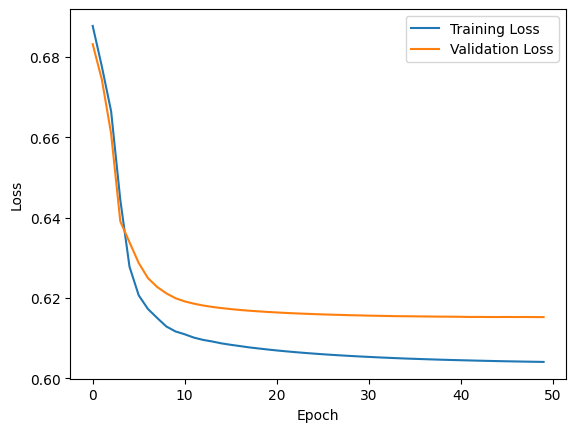

In [11]:
# plot training and validation loss over epochs
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
print("Test set results:")
accuracy, auc, avg_test_loss = evaluate_model(model, test_loader, loss_fun, device)
print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Test set results:
Accuracy: 0.7650, AUC: 0.7650


### 2 - PyTorch Implementation with MSE

### 3 - Manual Gradients and Updates

### 4 - Regularizers